# Testing STructured Additive REGression for nasty data distributions

- bulk data vs well-distributed data
- equidistant vs quantile based


## ToDo
- [x] Single point prediction
- [x] Extrapolation
- [x] Klemmen
- [x] Cost function partitioning
- [x] Multi-peak
- [x] Confidence Intervals
- [x] Prediction Intervals
- [x] Data Preprocessing and Quality Check
- [x] Fit Metric using Constraints

## IMPORTS

In [1]:
import numpy as np
import pandas as pd
import copy
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import ParameterGrid
from sklearn.utils import check_X_y 
from sklearn.metrics import mean_squared_error

from scipy.stats import t
from scipy.signal import find_peaks

from stareg.utils import check_constraint, test_model_against_constraint
from stareg import StarModel 
from stareg.utils import check_constraint_full_model, bar_chart_of_coefficient_difference_dataframe
from stareg import Smooths as s

## 1D Test Case

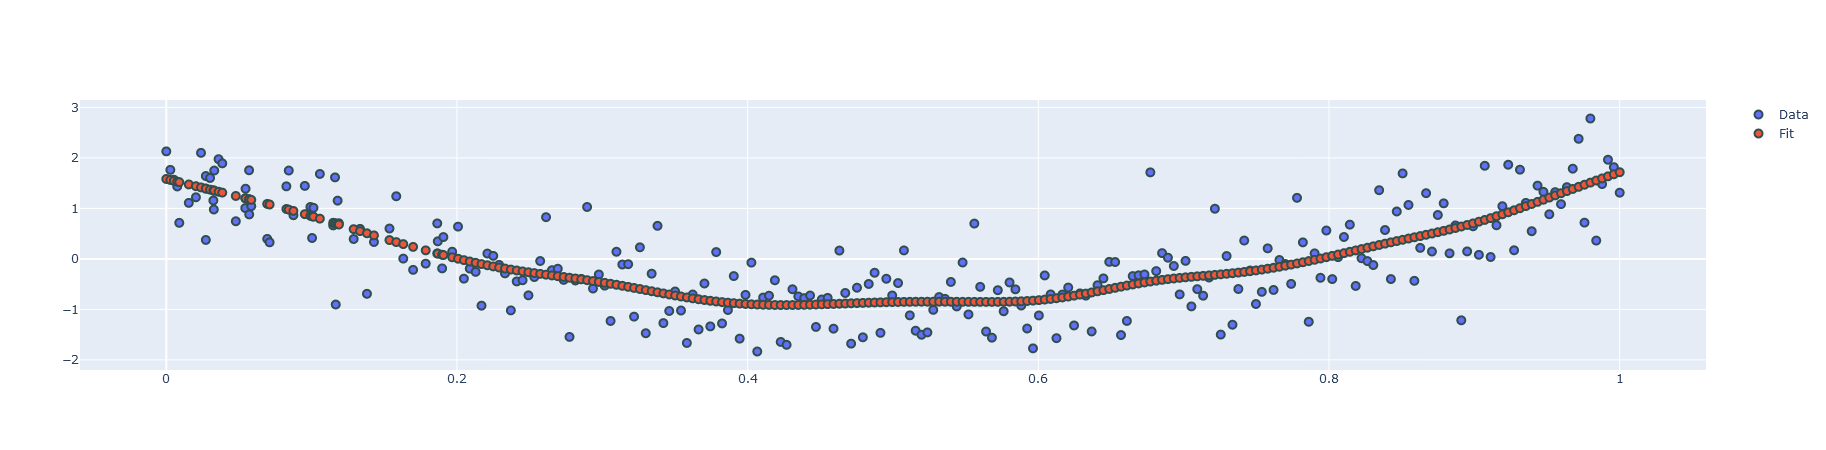

Violated Constraints: 1 from 35 


In [2]:
# try CV on 1-d dataset

# generate data
np.random.seed(42)
x_dense = np.random.random(50) * 0.2
x_sparse = np.linspace(0.2,1,200)
x_dense.sort()
x=np.concatenate((x_dense, x_sparse))
x = (x - x.min()) / (x.max() - x.min())
n_samples = len(x)
x = x.reshape((len(x), 1))
y_true = -20*np.exp(-(x-0.5)**2) 
#y = y_true + np.random.random(len(x)).reshape((len(x), 1))
y = y_true + np.random.normal(size=len(x)).reshape((len(x), 1))

# try data standardization
y = ( y - y.mean()) / y.std()
x_ep = np.concatenate((np.linspace(-0.5,0,103), np.linspace(1, 1.5, 103)))
y_ep_true = -20*np.exp(-(x_ep-0.5)**2) + 0.1*np.random.randn(len(x_ep),1)

# generate parameter grid
m1 = (("s(1)", "valley", 35, (10, 0), "equidistant"),)
M1 = StarModel(description=m1)
y_pred = M1.fit(X=x, y=y.ravel(), plot_=True)
#M1.calc_GCV(X=x, y=y.ravel(), n_grid=2, p_min=1e-2, plot_=True)

Metric =  0.38766
MSE =  0.3496239


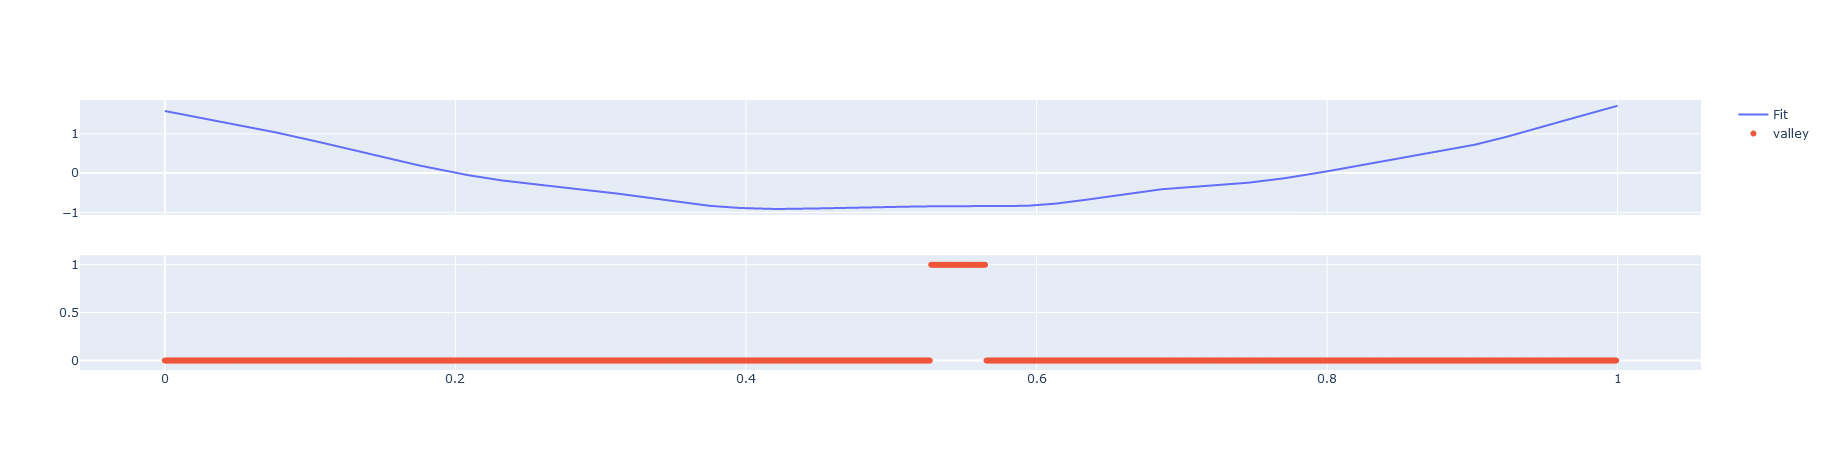

In [4]:
print("Metric = ", M1.eval_metric(X=x, y=y.ravel()))
print("MSE = ", M1.mse)
t = test_model_against_constraint(model=M1, plot_=True, dim=x.shape[1])

In [5]:
M1.describe_data(X=x, y=y, col_names=["Temp", "Q"])

,Temp,Q
count,250.000000,2.500000e+02
mean,0.495761,-2.998490e-15
std,0.294200,1.002006e+00
min,0.000000,-1.834474e+00
25%,0.246143,-7.115129e-01
50%,0.497428,-1.204489e-01
75%,0.748714,7.046829e-01
max,1.000000,2.780402e+00


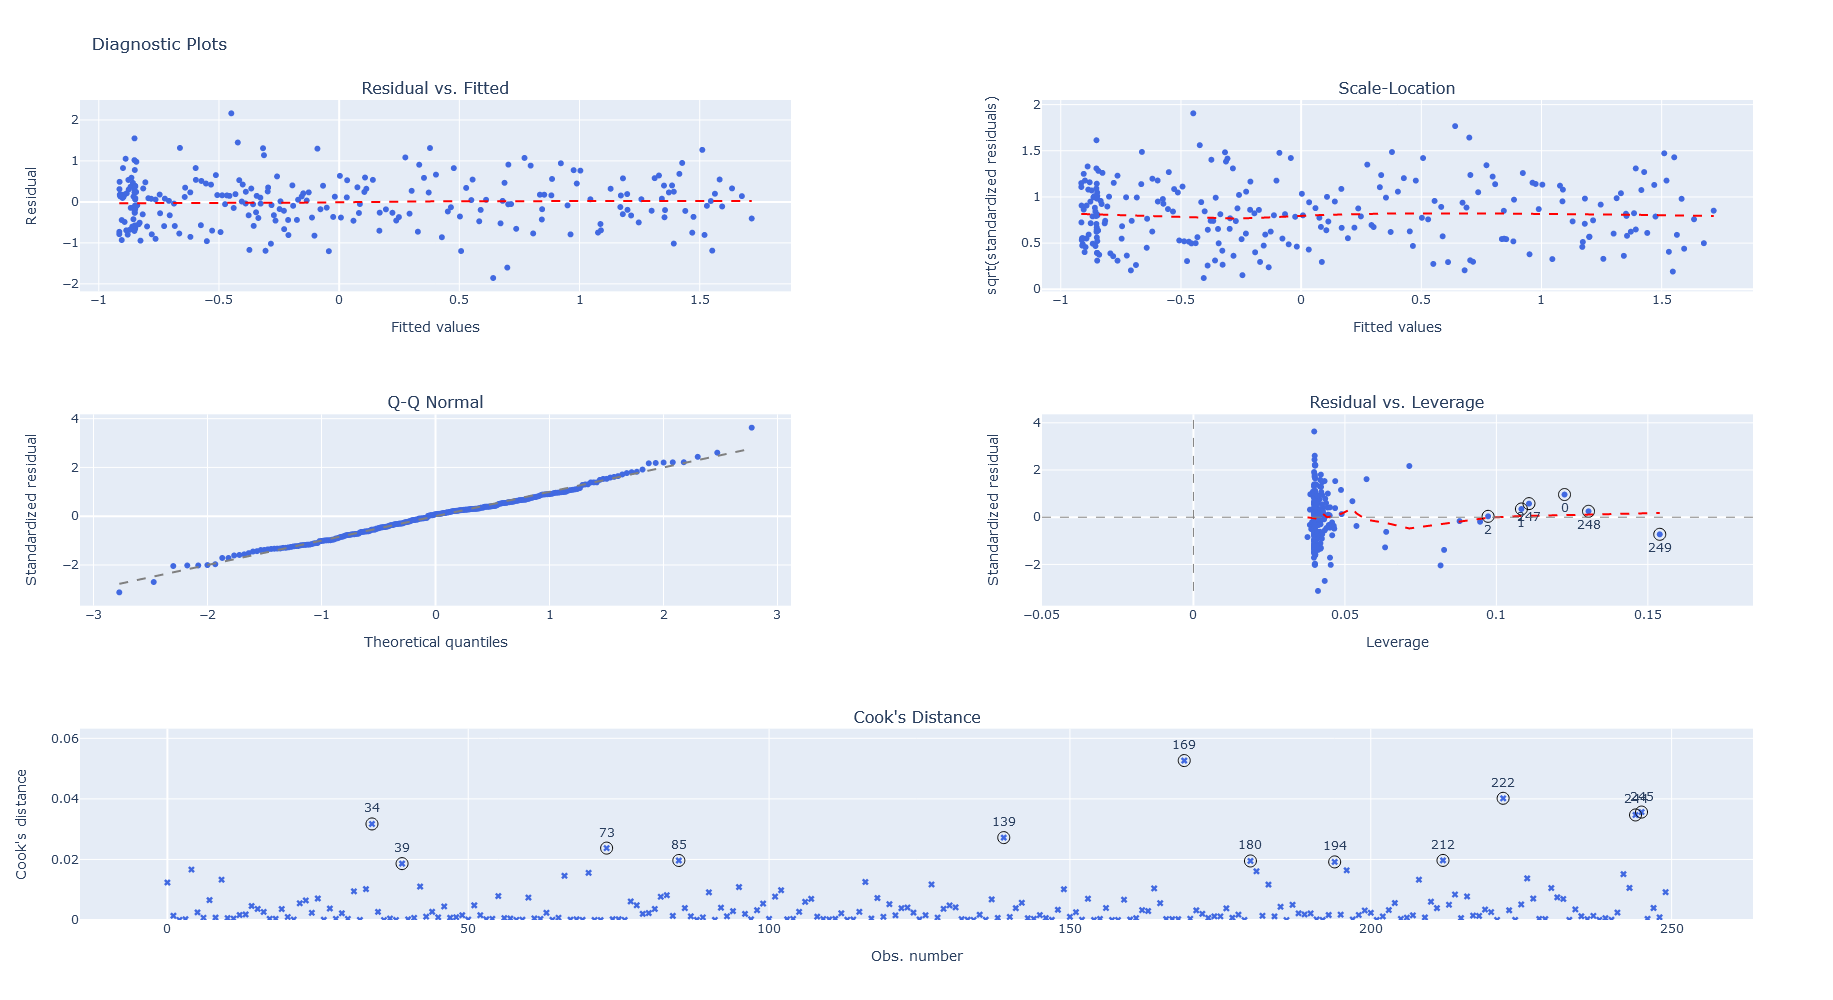

In [6]:
M1.plot_diagosticPlots(y=y)

# Extrapolation

In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from stareg import StarModel 
from stareg.bspline import Bspline
from scipy.stats import t

# test with different dataset
np.random.seed(41)
n_samples = 250
x = np.random.random(n_samples)
x.sort()
xmax, xmin = x.max(), x.min()
x = x
x = (x - xmin) / (xmax - xmin)

# test with linspace data
x = np.linspace(0,1,250)

noise = np.random.random(n_samples)
y_true = 2*np.exp(-(x - 0.4)**2 / 0.1) - 5.5*x**2 
y = y_true + noise*0.5
y = np.flip(y)
y = (y - y.mean()) / y.std()

n_param = 25
descr = ( ("s(1)", "peak", n_param, (0.1, 1000), "equidistant"), )

M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=False)

# extrapolation
x_right = np.linspace(1.00001,1.5,70)
x_left = np.linspace(-0.5, 0,70)

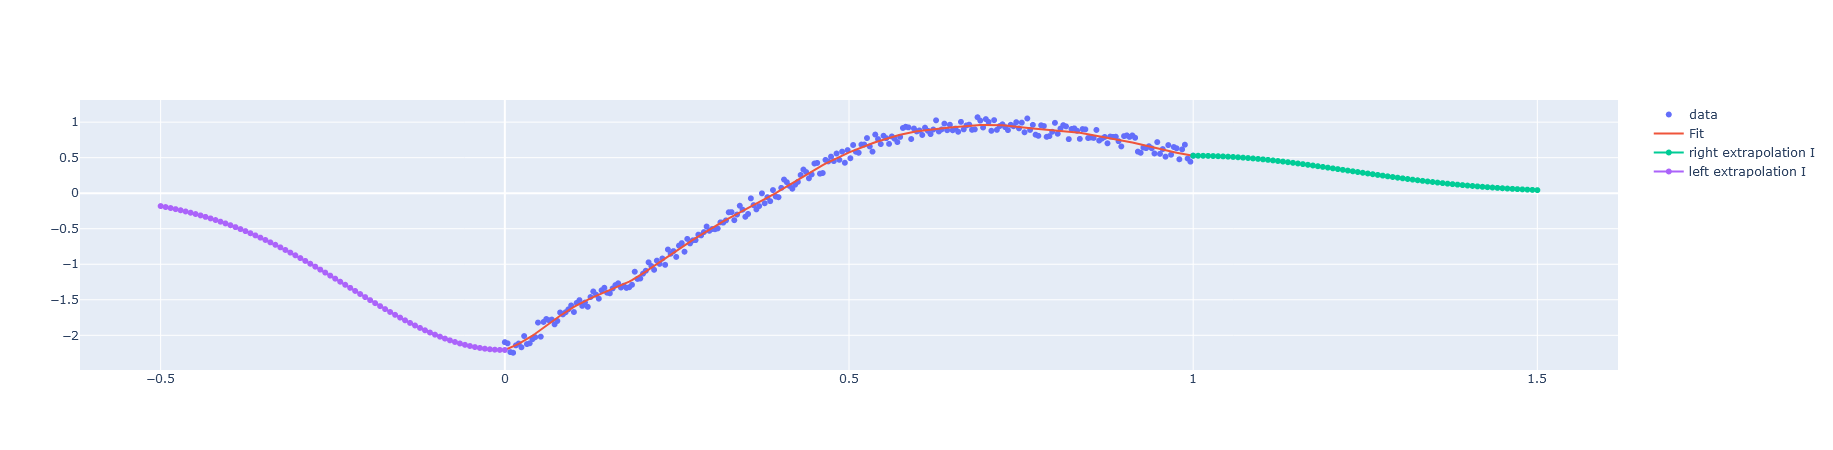

In [2]:
bfig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="data"))
fig.add_trace(go.Scatter(x=x, y=M.basis @ M.coef_, name="Fit"))
fig.add_trace(go.Scatter(x=x_right, y=M.predict(X=x_right.reshape((-1,1)), extrapol_type="zero", depth=10), mode="markers+lines", name="right extrapolation I "))
fig.add_trace(go.Scatter(x=x_left, y=M.predict(X=x_left.reshape((-1,1)), extrapol_type="zero", depth=10), mode="markers+lines", name="left extrapolation I "))


## EXTRAPOLATION 2D

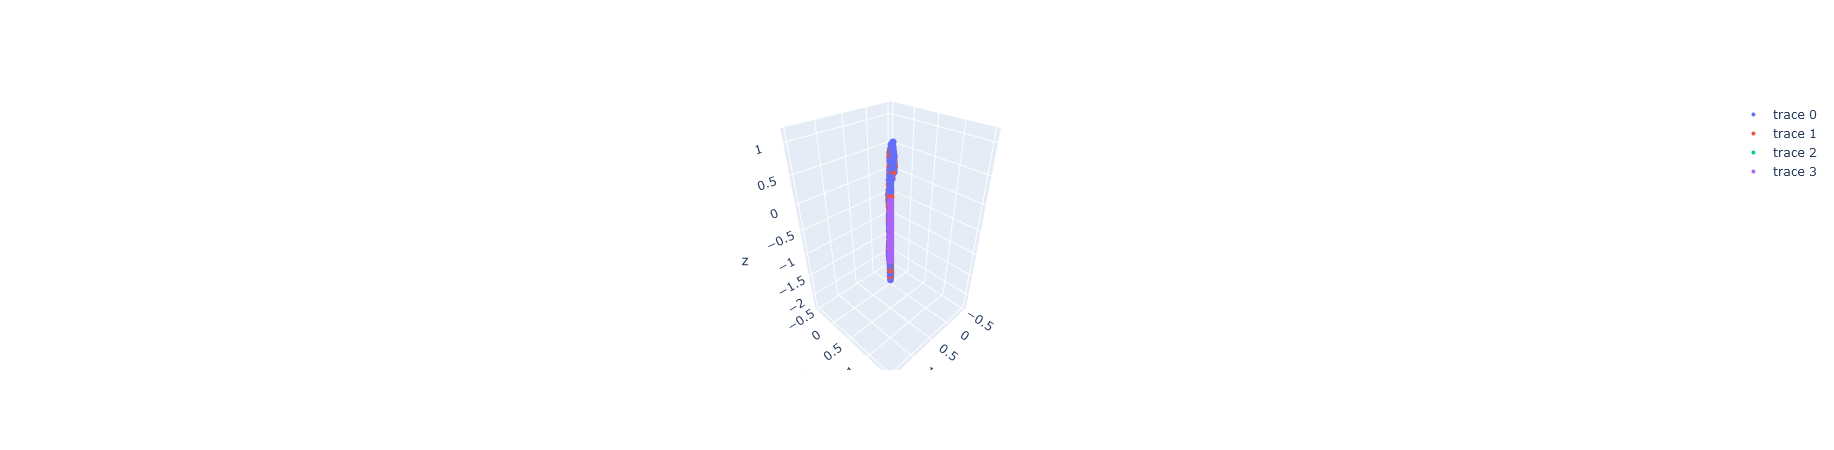

In [9]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from stareg import StarModel 
from stareg.bspline import Bspline
from scipy.stats import t
# test with different dataset
np.random.seed(41)
n_samples = 250
noise = np.random.random(n_samples)
x = np.random.random(2*n_samples).reshape(-1, 2)
x.sort(axis=0)
xmax, xmin = x.max(axis=0), x.min(axis=0)
x = x
x = (x - xmin) / (xmax - xmin)

y_true = 2*np.exp(-(x[:,0] - 0.4)**2 / 0.1) - 5.5*x[:,1]**2 
y = y_true + noise*0.5
y = np.flip(y)
y = (y - y.mean()) / y.std()

n_param = 25
descr = ( ("s(1)", "peak", n_param, (0.1, 1000), "equidistant"),
          ("s(2)", "inc", n_param, (0.1, 1000), "equidistant"), 
          ("t(1,2)", "smooth", (5,5), (0.1, 1000), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x, y=y, plot_=False)

# extrapolation
x_right = np.linspace(1.00001,1.5,70).reshape(-1,2)
x_left = np.linspace(-0.5, 0,70).reshape(-1,2)

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x[:,0], y=x[:,1], z=y, mode="markers", marker=dict(size=4)))
fig.add_trace(go.Scatter3d(x=x[:,0], y=x[:,1], z=M.basis @ M.coef_, mode="markers", marker=dict(size=4)))
fig.add_trace(go.Scatter3d(x=x_left[:,0], y=x_left[:,1], z=M.predict(X=x_left), mode="markers", marker=dict(size=4)))
fig.add_trace(go.Scatter3d(x=x_right[:,0], y=x_right[:,1], z=M.predict(X=x_right, extrapol_type="zero"), mode="markers", marker=dict(size=4)))


## Confidence Interval as given in Fahrmeir, Regression 2013   ----- ONLY VALID FOR LINEAR MODELS 
the CI is given as follows: $\hat \beta_j \pm t_{n-p}(1-\alpha/2) se_j$ with  $se_j = \sqrt{\text{diag } \widehat{\text{Cov}(\hat \beta)}}$ with $\widehat{\text{Cov}(\hat \beta)} = \hat \sigma_{REML}^2 (X'X)^{-1} = \frac{1}{n-p} \hat \epsilon' \hat \epsilon (X'X)^{-1}$ True

## Prediction Interval as given in Fahrmeir, Regression 2013  ---- ONLY VALID FOR LINEAR MODELS

the PI for point $x_0$ that is given by the model maxtrix row $x_0'$ is given by: $ x_0'\hat \beta_j \pm t_{n-p}(1-\alpha/2) \hat \sigma (1 + x_0'(X'X)^{-1}x_0)^{1/2}$  with  $\hat \sigma^2 = \hat \sigma_{REML}^2 = \frac{1}{n-p} \hat \epsilon' \hat \epsilon$ 

## Confidence Intervals and Bands for Nonparametric Regression Models
- rework the prediction and confidence intervals for the non-parametric regression 
- all given in Fahrmeir, 8.1.8 "General Scatterplot Smoothing"
  - linear smoother property: $\hat f = S y$
  - need the hat matrix
  - Confidence intervals vs confidence bands
    - Intervals: narrower, hold only for the point they are calculated for - p. 470 - given by $\hat f(z) \pm z_{1-\alpha / 2} \sigma \sqrt{s(z)'s(z)}$ with $s(z)' = z'(Z'Z + \lambda K)^{-1}Z'$

TODO:
- [ ] make CI 2D

In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from stareg import StarModel 
from stareg.bspline import Bspline
from scipy.stats import t
# test with different dataset
np.random.seed(41)
n_samples = 250
noise = np.random.random(n_samples)
x = np.random.random(2*n_samples).reshape(-1, 2)
x.sort(axis=0)
xmax, xmin = x.max(axis=0), x.min(axis=0)
x = x
x = (x - xmin) / (xmax - xmin)

y_true = 2*np.exp(-(x[:,0] - 0.4)**2 / 0.1) - 5.5*x[:,1]**2 
y = y_true + noise*0.5
y = np.flip(y)
y = (y - y.mean()) / y.std()

n_param = 25
descr = ( ("s(1)", "peak", n_param, (0.1, 1000), "equidistant"), )
#          ("s(2)", "inc", n_param, (0.1, 1000), "equidistant"), )
          #("t(1,2)", "smooth", (5,5), (0.1, 1000), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x[:,1].reshape(-1,1), y=y, plot_=False)

StarModel(s(1)={'constraint': 'peak', 'knot_type': 'equidistant',
                'lam': {'constraint': 1000, 'smoothness': 0.1}, 'n_param': 25})

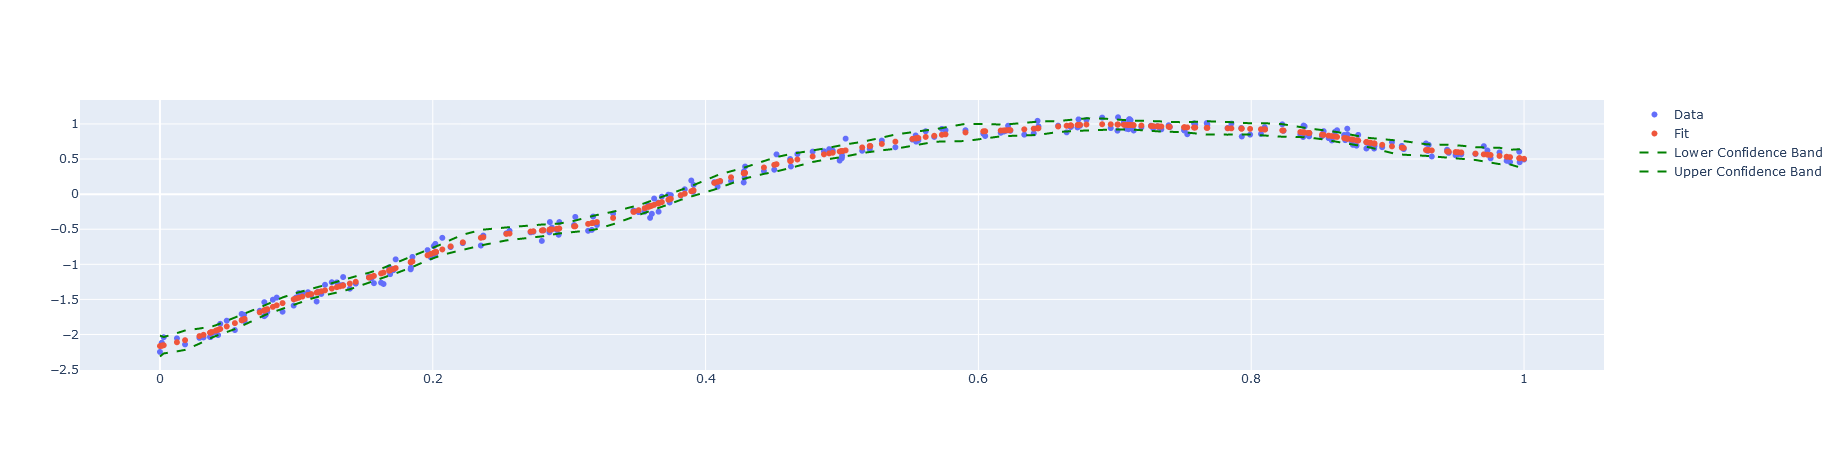

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x[:,1].ravel(), y=y.ravel(), mode="markers", name="Data"))
fig.add_trace(go.Scatter(x=x[:,1].ravel(), y=M.basis @ M.coef_, name="Fit", mode="markers"))
M.plot_confidence_intervals(fig=fig, X=x[:,1].reshape(-1,1))
fig.show()


# Multi-Peak

- [x] test if the "security" non-constraint splines (4 splines in the peak region are currently not constraint) in the peak and valley constraint are really needed for smooth function fitting.
        -> not needed, changed to only one non-constraint spline
- [x] implement multi-peak
- [x] implement multi-valley
- [x] implement peak-valley or other way
        -> basics work, but it needs polishing
- [ ] think of a way to specify multi-peak in the model description
- [ ] Testing !

**Test for  Multi Peak Data**

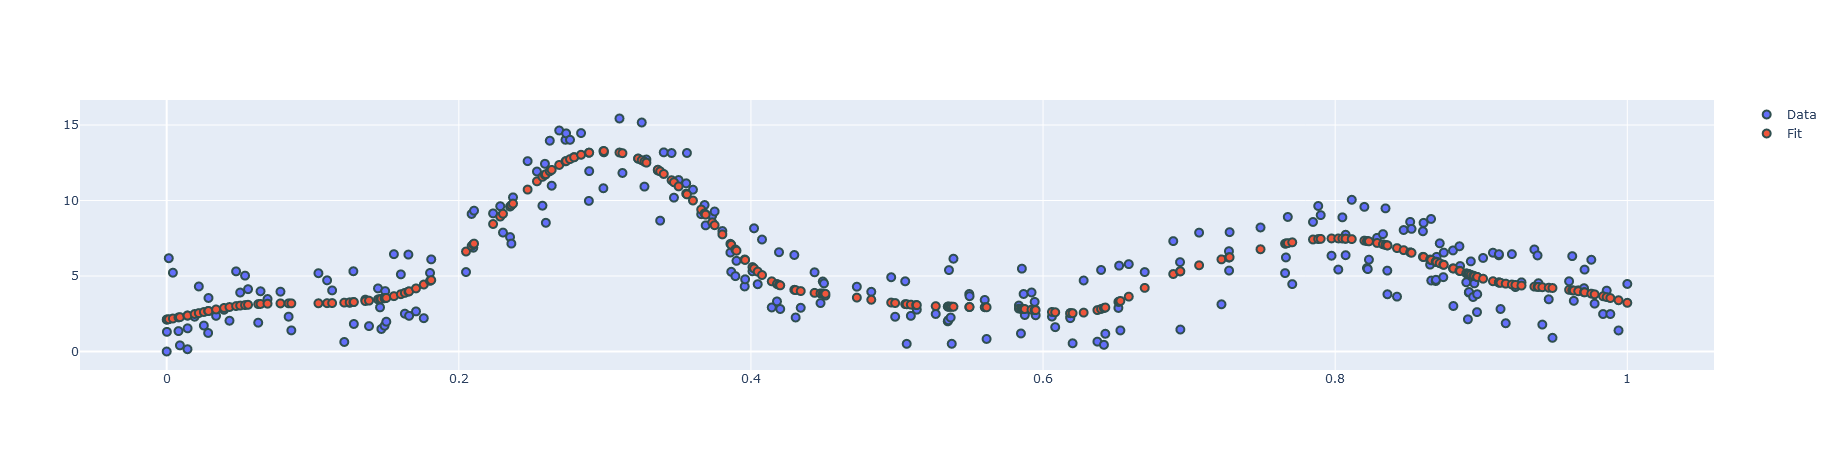

Violated Constraints: 6 from 25 


StarModel(s(1)={'constraint': 'multi-peak', 'knot_type': 'equidistant',
                'lam': {'constraint': 1000, 'smoothness': 0.1}, 'n_param': 25})

In [7]:
import numpy as np
import plotly.graph_objects as go
from stareg.star_model import StarModel
x = np.random.random(250)
x.sort()
x = (x - x.min()) / (x.max() - x.min())
noise = np.random.random(250)*1.25
y_true = 10*np.exp(-(x-0.3)**2 / 0.01 ) + 4*np.exp(-(x-0.8)**2/0.01)
y = y_true + noise*5
n_param = 25
descr = ( ("s(1)", "multi-peak", n_param, (0.1, 1000), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)

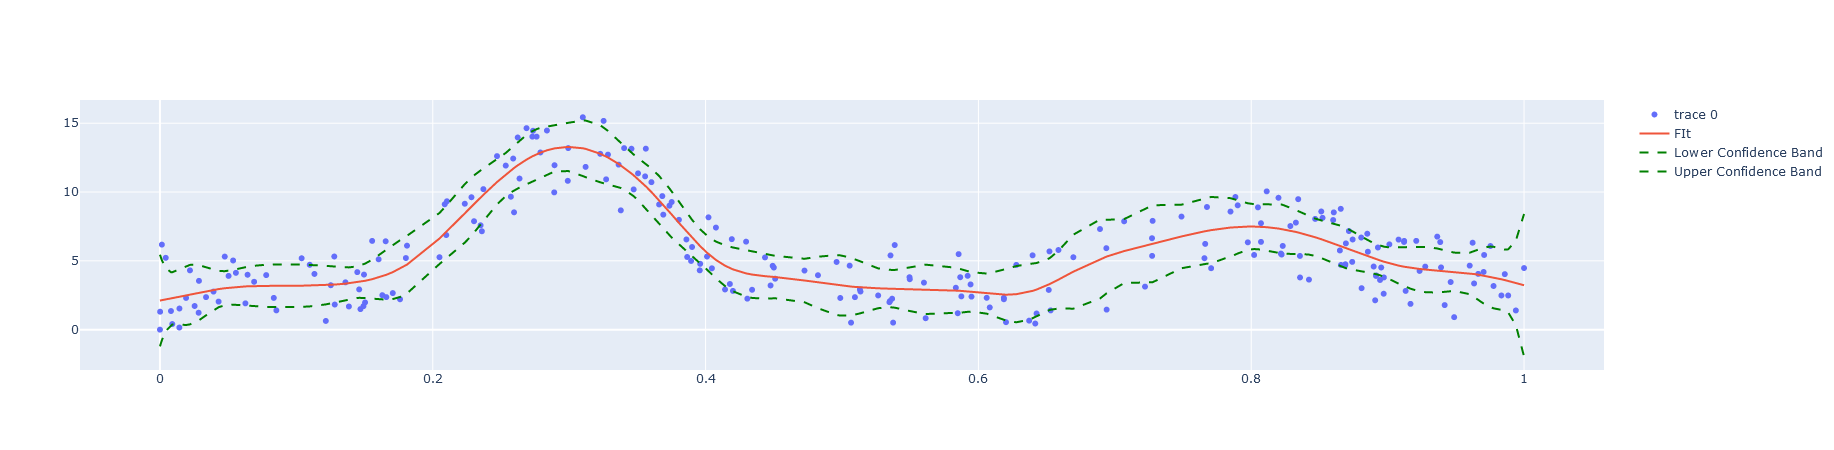

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers"))
fig.add_trace(go.Scatter(x=x, y=M.basis @M.coef_, mode="lines", name="FIt"))
M.plot_confidence_intervals(X=x.reshape(-1,1), y=y, fig=fig)


**Test for Multi-Valley Data**

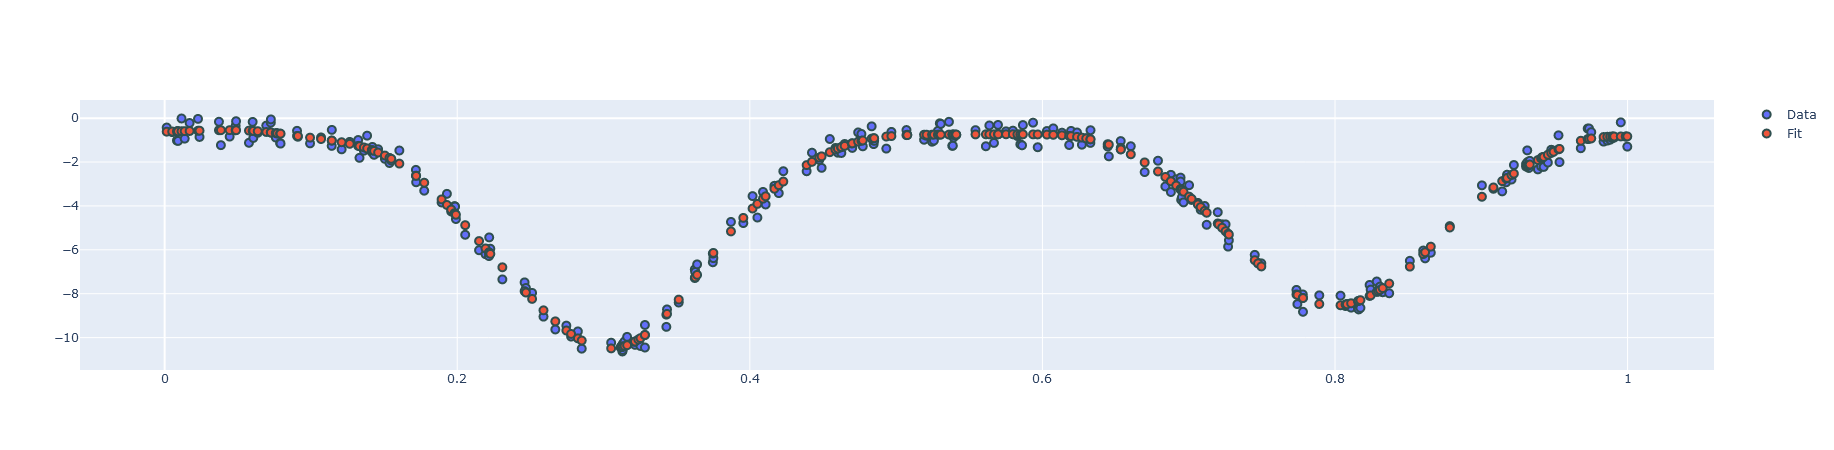

Violated Constraints: 5 from 35 


StarModel(s(1)={'constraint': 'multi-valley', 'knot_type': 'equidistant',
                'lam': {'constraint': 1200, 'smoothness': 0.1}, 'n_param': 35})

In [9]:
import numpy as np
from stareg.star_model import StarModel
x = np.random.random(250)
x.sort()
noise = np.random.random(250)*1.25
y = 10*np.exp(-(x-0.3)**2 / 0.01 ) + 8*np.exp(-(x-0.8)**2/0.01) + noise
y = -1*y
descr = ( ("s(1)", "multi-valley", 35, (0.1, 1200), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)

**Test for Peak-Valley Data**

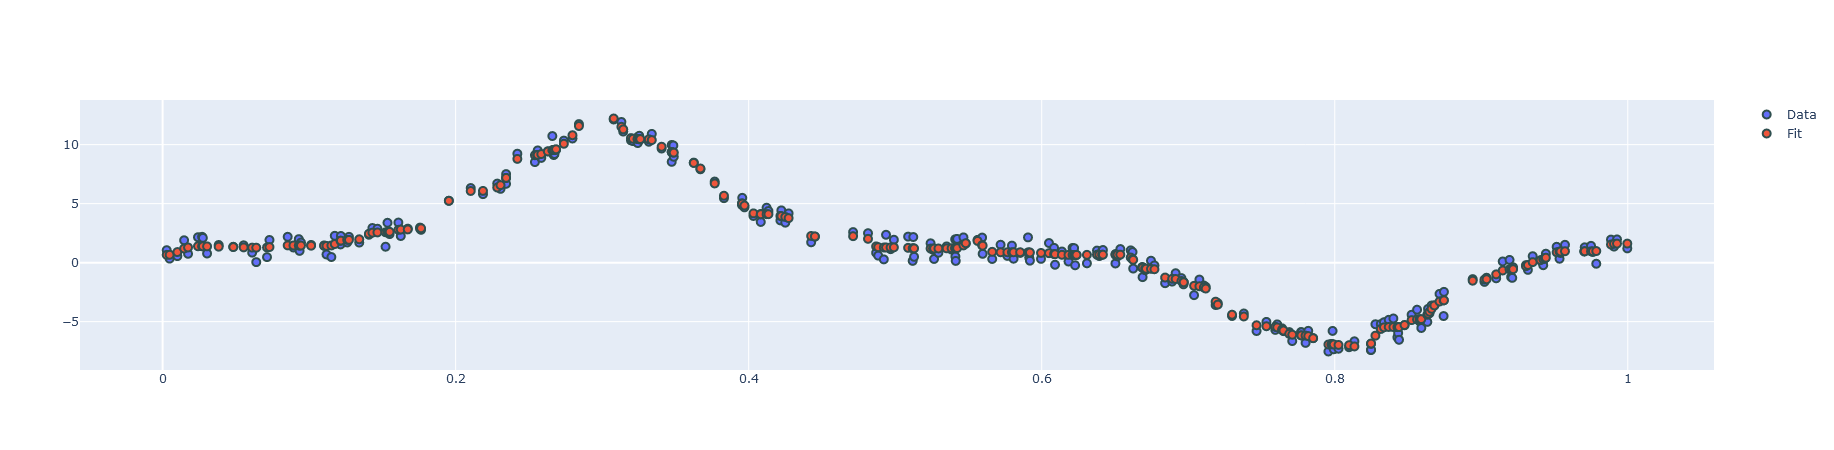

Violated Constraints: 99 from 205 


StarModel(s(1)={'constraint': 'peak-and-valley', 'knot_type': 'equidistant',
                'lam': {'constraint': 100, 'smoothness': 0.1}, 'n_param': 205})

In [7]:
import numpy as np
from stareg.star_model import StarModel
x = np.random.random(250)
x.sort()
noise = np.random.random(250)*2.25
y = 10*np.exp(-(x-0.3)**2 / 0.01 ) - 8*np.exp(-(x-0.8)**2/0.01) + 1*noise #+ 10*x'
#px.scatter(x=x, y=y)
n_param = 205

descr = ( ("s(1)", "peak-and-valley", n_param, (0.1, 100), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)

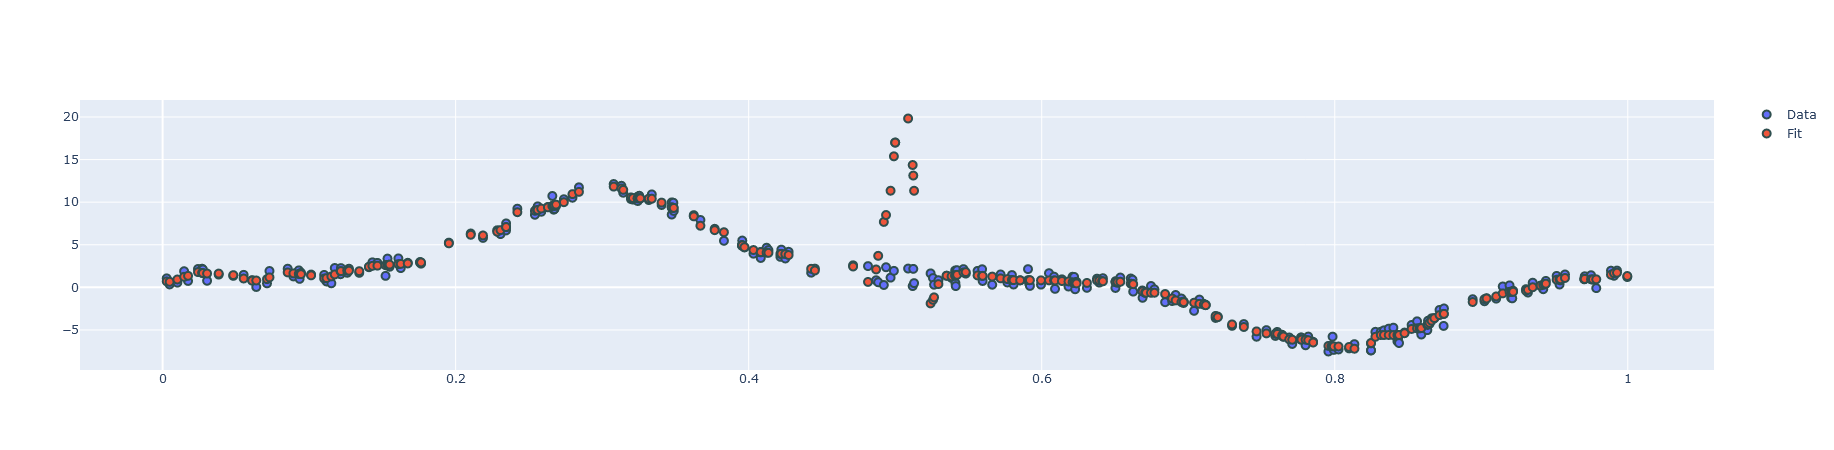

Violated Constraints: 79 from 205 


StarModel(s(1)={'constraint': 'peak-and-valley', 'knot_type': 'equidistant',
                'lam': {'constraint': 100, 'smoothness': 0.1}, 'n_param': 205})

In [8]:
M2 = StarModel(description=descr)
M2.weighted_fit(X=x.reshape(-1,1), y=y,critical_point=np.array([0.5, 17]).reshape((-1,2)), weights=10000)

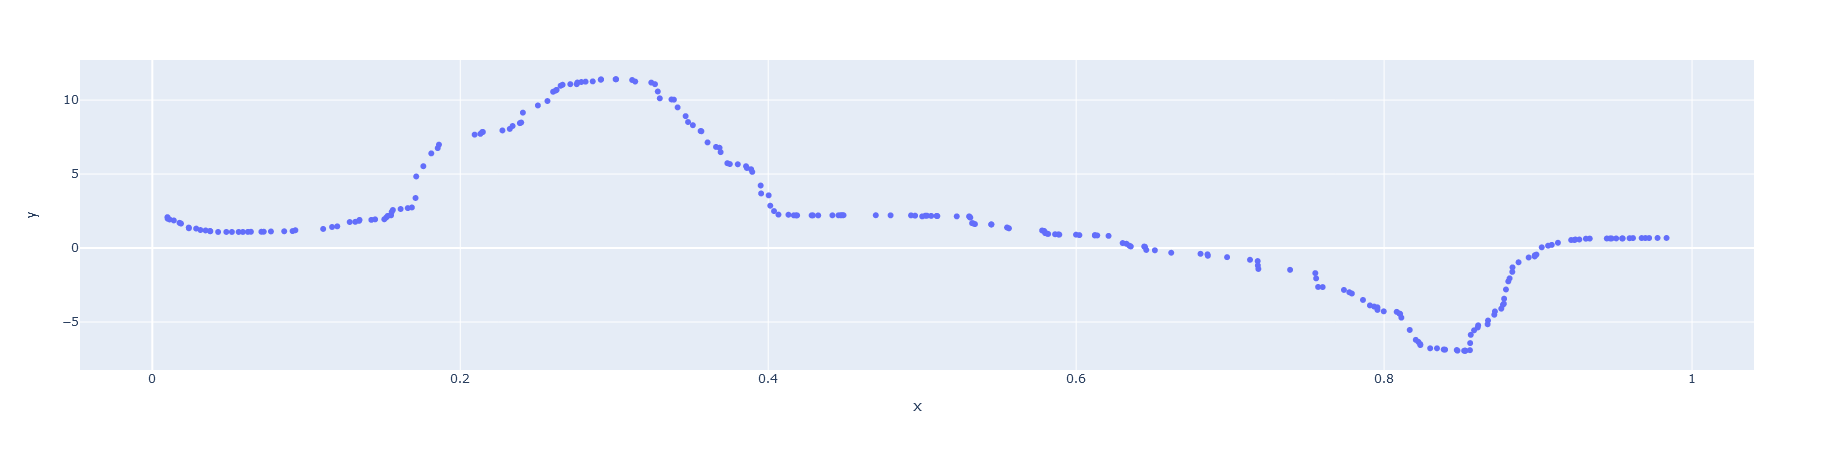

In [37]:
px.scatter(x=XXX.ravel(), y=M2.basis @ M2.coef_)

In [16]:
cp =np.array([0.5, 17]).reshape(-1,2)

In [17]:
cp.shape

(1, 2)

In [40]:
X_new = np.vstack((x.reshape(-1,1), cp[:,:-1]))

In [41]:
XXX.shape

(251, 1)

In [49]:
w = np.ones(X_new.shape[0])
w[-cp.shape[0]:] = 1000


In [50]:
w

array([   1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,

In [46]:
X_new

array([[0.00476797],
       [0.0105903 ],
       [0.01688433],
       [0.02434813],
       [0.02488003],
       [0.02549184],
       [0.02938993],
       [0.0339935 ],
       [0.03638539],
       [0.05281915],
       [0.06045   ],
       [0.06047162],
       [0.06160132],
       [0.06498979],
       [0.06974342],
       [0.0797076 ],
       [0.08418708],
       [0.08593158],
       [0.08691361],
       [0.09166084],
       [0.09248335],
       [0.09366243],
       [0.10605304],
       [0.11087786],
       [0.11148231],
       [0.11633971],
       [0.13241807],
       [0.13675819],
       [0.14789641],
       [0.15302539],
       [0.15641728],
       [0.15799909],
       [0.16003126],
       [0.16156422],
       [0.17543233],
       [0.17888806],
       [0.19271606],
       [0.1943042 ],
       [0.19608924],
       [0.19904162],
       [0.20038832],
       [0.20977547],
       [0.21128937],
       [0.21448699],
       [0.21490969],
       [0.22557114],
       [0.22917265],
       [0.230